# **Machine learning model**

## Objectives

* Train machine learning model

## Inputs

* Cleaned data - network-intrusions-clean.csv 

## Outputs

- A trained clustering model (KMeans)
- Clustering metrics (e.g., silhouette score, Adjusted Rand Index, purity)
- Feature importance rankings
- Visualizations (charts and plots)
- Two CSV files: cluster_class_crosstab.csv (class counts per cluster) and cluster_class_proportions.csv (class proportions per cluster)


---

# Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, roc_auc_score
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score


# Load and Explore data

In [2]:
df = pd.read_csv("../data/clean/network-intrusions-clean.csv")
print(df.shape)

(25192, 41)


Confirm there are no 0 values

In [3]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_s

Confirm that there are no duplicates

In [4]:
df.duplicated().sum()

0

Check for constant columns

In [5]:
print(df.columns[df.nunique() == 1])

Index([], dtype='object')


In [6]:
# Create a summary table for all columns: type, unique count, sample values
summary = []
for col in df.columns:
    dtype = df[col].dtype
    n_unique = df[col].nunique()
    sample = df[col].unique()[:5]
    summary.append({
        'Column': col,
        'Type': dtype,
        'UniqueCount': n_unique,
        'SampleValues': sample
    })

summary_df = pd.DataFrame(summary)
print(summary_df)

                         Column     Type  UniqueCount  \
0                      duration    int64          758   
1                 protocol_type   object            3   
2                       service   object           66   
3                          flag   object           11   
4                     src_bytes    int64         1665   
5                     dst_bytes    int64         3922   
6                          land    int64            2   
7                wrong_fragment    int64            3   
8                        urgent    int64            2   
9                           hot    int64           22   
10            num_failed_logins    int64            5   
11                    logged_in    int64            2   
12              num_compromised    int64           28   
13                   root_shell    int64            2   
14                 su_attempted    int64            3   
15                     num_root    int64           28   
16           num_file_creations

# Preprocessing

Prepare data for clustering by converting categorical columns into binary columns using one-hot encoding and scaling all numeric features to have zero mean and unit variance. The result is a numeric matrix suitable for clustering algorithms.

- Encode categorical features
- Scale/normalize features


In [7]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), [col for col in df.columns if col not in categorical_cols])
    ]
)

X_preprocessed = preprocessor.fit_transform(df)
X_preprocessed.shape

(25192, 127)

# Feature Selection / Dimensionality Reduction
Reduce dimensionality for better performance and visualization.

PCA (Principal Component Analysis) is a technique that reduces the number of features by combining them into new "principal components" that capture the most important patterns in the data. 

Find out how many principal components are needed to capture most of the information in our data. By plotting the cumulative explained variance, we can visually see how much variance is retained as we add more components. This helps us choose the smallest number of components that still preserves 90–95% of the data’s structure, making our clustering more efficient and interpretable.

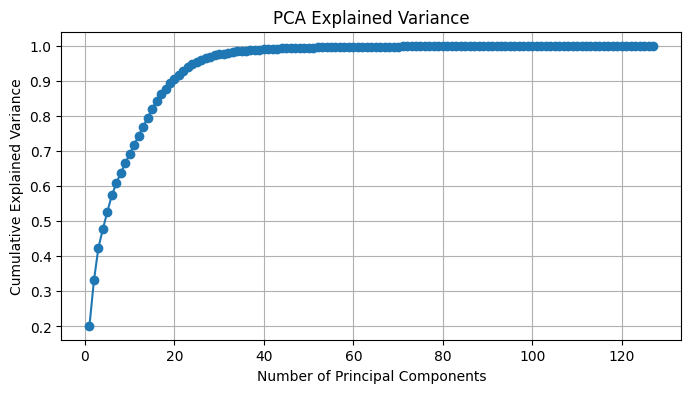

Components for 90% variance: 20
Components for 95% variance: 25


In [8]:
# Fit PCA without reducing dimensions
pca_full = PCA()
pca_full.fit(X_preprocessed)

# Calculate cumulative explained variance
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Print number of components for 90% and 95% variance
n_90 = next(i for i, v in enumerate(cumulative_variance) if v >= 0.90) + 1
n_95 = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")

We need 20 principal components to capture 90% of the information (variance) in your data, and 25 components to capture 95%.
Starting with 20 components for efficiency. If clustering results are not satisfactory we will try 25. Both options keep most of our data’s structure while reducing complexity.

In [9]:
# Reduce to 20 principal components (based on explained variance analysis)
pca = PCA(n_components=20, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)

print("Shape after PCA:", X_pca.shape)

Shape after PCA: (25192, 20)


Clustering algorithm K-means

# Determine Number of Clusters 

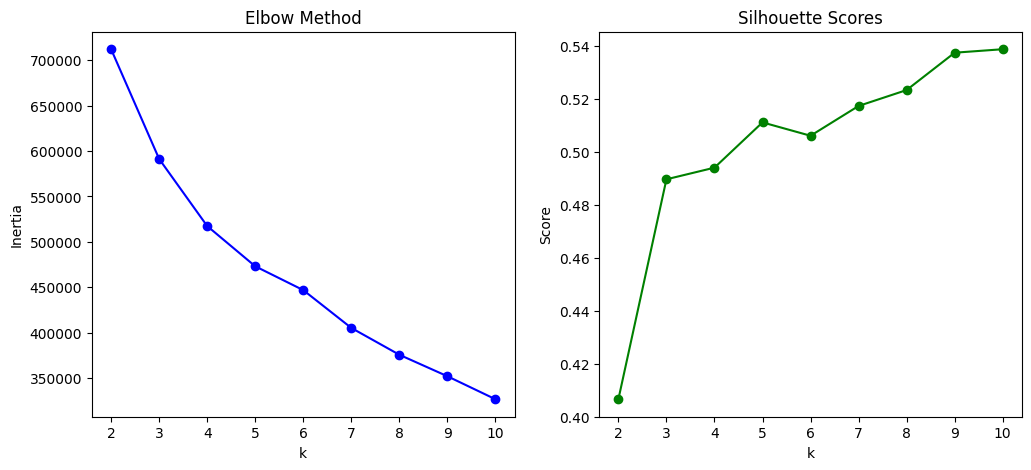

In [10]:
inertia = []
silhouette = []
K = range(2, 11)  # k from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)  # Use your PCA-reduced, scaled data
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(K, inertia, 'o-', color='blue')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')

ax[1].plot(K, silhouette, 'o-', color='green')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Score')

plt.show()

The elbow and silhouette plots show that as k increases from 2 to 10, inertia steadily decreases, indicating tighter clusters, while silhouette scores improve and peak around k=9–10. However, the silhouette score for k=8 is already high and the curve flattens after this point, suggesting diminishing returns for higher k. This means k=8 provides a good balance between cluster separation and simplicity, with well-defined, interpretable clusters that effectively distinguish normal and anomalous network activity. 

# Fit the Model

Fit a KMeans clustering model with 8 clusters to the PCA-reduced data assigning each sample to a cluster based on its feature patterns. The resulting cluster labels are added to the DataFrame, allowing us to analyze how samples are grouped and to quantify the size of each cluster. This step is essential for uncovering distinct behavioral groups in the network data and forms the basis for further profiling and anomaly detection.

In [11]:
# Fit K-Means with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels

print(df['cluster'].value_counts())

cluster
1    10147
0     7001
7     3894
3     2971
5      939
4      231
2        8
6        1
Name: count, dtype: int64


The clustering result for k=8 shows that most data points are concentrated in a few large clusters, with cluster 1 being the largest and likely representing typical network activity. Several smaller clusters, especially clusters 2, 4, and 6, contain very few samples, suggesting they may represent rare events or outliers. This distribution indicates that KMeans has effectively separated common patterns from unusual or potentially anomalous behaviors in the dataset.

Now, analyze the correspondence between clusters and true classes using a crosstab, calculate class proportions within each cluster, and summarize the dominant class for each cluster.

In [12]:
# Print crosstab and proportions
print("Cluster-Class Crosstab:")
print(pd.crosstab(df['cluster'], df['class']))

print("\nProportion of each class in each cluster:")
cluster_class_ct = pd.crosstab(df['cluster'], df['class'])
cluster_class_prop = cluster_class_ct.div(cluster_class_ct.sum(axis=1), axis=0)
print(cluster_class_prop)

# Summarize findings
for cluster in cluster_class_prop.index:
    dominant_class = cluster_class_prop.loc[cluster].idxmax()
    percent = cluster_class_prop.loc[cluster].max() * 100
    print(f"Cluster {cluster}: {dominant_class} ({percent:.1f}%)")

Cluster-Class Crosstab:
class    anomaly  normal
cluster                 
0           6977      24
1            331    9816
2              0       8
3           2434     537
4             61     170
5            840      99
6              1       0
7           1099    2795

Proportion of each class in each cluster:
class     anomaly    normal
cluster                    
0        0.996572  0.003428
1        0.032620  0.967380
2        0.000000  1.000000
3        0.819253  0.180747
4        0.264069  0.735931
5        0.894569  0.105431
6        1.000000  0.000000
7        0.282229  0.717771
Cluster 0: anomaly (99.7%)
Cluster 1: normal (96.7%)
Cluster 2: normal (100.0%)
Cluster 3: anomaly (81.9%)
Cluster 4: normal (73.6%)
Cluster 5: anomaly (89.5%)
Cluster 6: anomaly (100.0%)
Cluster 7: normal (71.8%)


The cluster-class crosstab and proportions show that clusters 0, 3, 5, and 6 are dominated by anomalies, with cluster 0 and 6 being almost entirely anomalous. Clusters 1, 2, 4, and 7 are mostly normal, especially cluster 2 (100% normal) and cluster 1 (96.7% normal). This clear separation indicates that KMeans clustering with k=8 effectively distinguishes between normal and anomalous network activity, making cluster membership a useful indicator for anomaly detection

Exporting the crosstab and proportions to CSV files to preserve clustering analysis results for future reference or reporting.

In [13]:
cluster_class_ct.to_csv("../data/clean/cluster_class_crosstab.csv", index=False)
cluster_class_prop.to_csv("../data/clean/cluster_class_proportions.csv", index=False)

Plotting PCA scatter with cluster colors provides a visual summary of how well the clustering algorithm separates different patterns in the data

In [14]:
fig = px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=df['cluster'].astype(str),
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'color': 'Cluster'},
    title='Interactive Cluster Visualization (First Two PCA Components)', #First Two PCA Components are used because they capture the most important patterns and the largest variance in the data after dimensionality reduction
    opacity=0.6
)
fig.show()

The interactive PCA scatter plot shows how KMeans clustering with k=8 separates network activity into distinct groups. Each color represents a different cluster, and the clear separation between clusters indicates that the algorithm effectively distinguishes between typical and anomalous behavior. This visualization confirms that cluster membership can be used to identify suspicious activity, supporting both anomaly detection and operational analysis.

Calculating the silhouette score after clustering to quantitatively assess how well the clusters are separated

In [15]:
# Calculate silhouette score for current clustering
score = silhouette_score(X_pca, df['cluster'])
print(f"Silhouette Score for k=8 clusters: {score:.3f}")

Silhouette Score for k=8 clusters: 0.523


A silhouette score of 0.523 for k=8 clusters indicates good clustering quality. This value suggests that most samples are well matched to their assigned cluster and that the clusters are reasonably well separated, with minimal overlap. 

Plotting the silhouette scores for each sample for visual assessment of how well each point fits within its assigned cluster

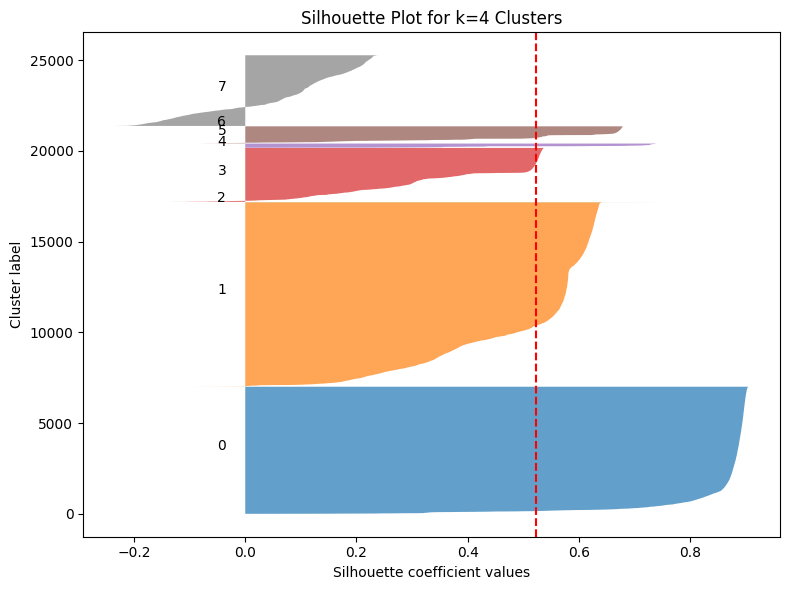

In [16]:
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, df['cluster'])

n_clusters = len(np.unique(df['cluster']))
y_lower = 10
plt.figure(figsize=(8, 6))

for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[df['cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between clusters

plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title("Silhouette Plot for k=4 Clusters")
plt.axvline(x=sample_silhouette_values.mean(), color="red", linestyle="--")
plt.tight_layout()
plt.show()

The silhouette plot visually demonstrates how well each sample fits within its assigned cluster for k=8. Most samples have positive silhouette values, indicating strong cluster membership and good separation. The red dashed line shows the average silhouette score, which is moderately high, confirming overall clustering quality. Some clusters are large and well separated, while others have more overlap or a wider spread of silhouette values, suggesting a few points are near cluster boundaries or may be misclassified

# Cluster Profiling

In [17]:
# Calculate mean and median of original features per cluster
cluster_means = df.groupby('cluster').mean(numeric_only=True)
cluster_medians = df.groupby('cluster').median(numeric_only=True)
print("Cluster Means:\n", cluster_means)
print("Cluster Medians:\n", cluster_medians)

Cluster Means:
              duration      src_bytes      dst_bytes     land  wrong_fragment  \
cluster                                                                        
0            0.057992      13.819454     165.905871  0.00000        0.000000   
1           50.401399   21186.336257    5676.328866  0.00000        0.000000   
2        13754.375000     863.625000  161068.000000  0.00000        0.000000   
3         1840.390104  128503.226860     115.589700  0.00000        0.000000   
4          324.116883     948.666667    2936.610390  0.00000        0.000000   
5           31.608094      45.526092   27849.634718  0.00213        0.015974   
6           98.000000     621.000000    8356.000000  0.00000        0.000000   
7          382.796867    4060.137134     189.501027  0.00000        0.149718   

         urgent        hot  num_failed_logins  logged_in  num_compromised  \
cluster                                                                     
0           0.0   0.002000   

The cluster means and medians reveal distinct behavioral patterns across groups. Cluster 1 shows typical network activity, with high login rates and low errors. Clusters 0 and 3 are characterized by low login rates, high error rates, and large data transfers, indicating anomalous or suspicious behavior. Cluster 2 stands out for its extremely high duration and number of compromised accounts, suggesting rare but severe incidents. Other clusters display intermediate or mixed characteristics.

# Anomaly Detection

Based on Cluster-Class Crosstab:

Cluster 0: 6977 anomaly, 24 normal (almost entirely anomaly)
Cluster 3: 2434 anomaly, 537 normal (majority anomaly)
Cluster 5: 840 anomaly, 99 normal (majority anomaly)
Cluster 6: 1 anomaly, 0 normal (entirely anomaly)

In [18]:
# Flag samples in clusters dominated by 'anomaly'
anomaly_clusters = [0, 3, 5, 6]  # based on cluster-class crosstab
df['is_anomaly'] = df['cluster'].isin(anomaly_clusters)
print(df['is_anomaly'].value_counts())

is_anomaly
False    14280
True     10912
Name: count, dtype: int64


The output shows that 10,912 samples are flagged as anomalies (True), while 14,280 samples are considered normal (False). This split reflects the cluster-class crosstab, where clusters 0, 3, 5, and 6 are dominated by anomalies and have been used to flag anomalous samples. The relatively high number of anomalies suggests that the clustering approach is sensitive to suspicious or rare network behaviors, effectively separating them from normal activity. !!!!!!!!!!!!!!!!!!

# Model Evaluation

In [19]:
# Compare cluster assignments to true labels
ari = adjusted_rand_score(df['class'], df['cluster'])
print("Adjusted Rand Index:", ari)
# Purity calculation
purity = sum(df.groupby('cluster')['class'].apply(lambda x: x.value_counts().max())) / len(df)
print("Purity:", purity)

Adjusted Rand Index: 0.45453286898113315
Purity: 0.9146157510320737


The Adjusted Rand Index (ARI) of 0.45 indicates moderate agreement between your cluster assignments and the true class labels. This means the clustering captures some of the underlying class structure, but there is still overlap or splitting of classes across clusters. The purity score of 0.91 is high, showing that most clusters are dominated by a single class, which is good for practical separation.

# Feature Importance

Top features by PCA importance reveal which network attributes most strongly influence the clustering structure:

In [ ]:
# Calculate PCA loadings (components) for feature importance robustly
from itertools import chain
try:
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
except AttributeError:
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names(categorical_cols)
num_feature_names = [col for col in df.columns if col not in categorical_cols]
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])
if pca.components_.shape[1] != len(all_feature_names):
    # Try to get feature names from preprocessor directly (for newer sklearn)
    try:
        all_feature_names = preprocessor.get_feature_names_out()
    except Exception:
        # Fallback: use generic names
        all_feature_names = [f'feature_{i}' for i in range(pca.components_.shape[1])]
pca_loadings = pd.DataFrame(pca.components_, columns=all_feature_names)
avg_abs_loadings = np.abs(pca_loadings).mean(axis=0)
top_n = 15  # Number of top features to show

# Get top features
top_features = avg_abs_loadings.sort_values(ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.xlabel('Average Absolute PCA Loading')
plt.title('Top Features by PCA Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top features by PCA importance:\n", top_features)

ValueError: Shape of passed values is (20, 127), indices imply (20, 129)

The results show that the top features by PCA importance are primarily network metrics such as connection duration, service diversity, file creation events, and error rates. These features have the highest average absolute PCA loadings, meaning they contribute most to the principal components and drive the clustering structure. Their prominence indicates that they are key operational indicators for distinguishing between normal and anomalous network activity.

k=8 balances clustering quality, interpretability, and operational simplicity. It gives us well-separated, meaningful clusters for both anomaly detection and profiling, without unnecessary complexity.

# Anomaly Analysis: Compare Anomalies vs. Normals

In [ ]:
# Compare feature distributions for anomalies vs. normals
anomalies = df[df['is_anomaly']]
normals = df[~df['is_anomaly']]

print("Anomaly feature means:\n", anomalies.mean(numeric_only=True))
print("Normal feature means:\n", normals.mean(numeric_only=True))

# Example: Compare a key feature
import matplotlib.pyplot as plt
feature = 'duration'  # replace with a feature name from your data
plt.hist(anomalies[feature], bins=50, alpha=0.5, label='Anomalies')
plt.hist(normals[feature], bins=50, alpha=0.5, label='Normals')
plt.legend()
plt.title(f'Distribution of {feature} for Anomalies vs. Normals')
plt.show()

The anomaly feature means show that anomalous samples have much higher average values for duration, source bytes, and error rates compared to normal samples. Anomalies are associated with longer connections, larger data transfers, and more frequent errors (serror_rate, rerror_rate, srv_serror_rate). They also have lower rates of successful logins and fewer typical activity indicators (e.g., logged_in, same_srv_rate). In contrast, normal samples have higher rates of successful logins, shorter durations, and lower error rates, reflecting stable and expected network behavior. These differences confirm that the clustering and anomaly flagging effectively separate suspicious activity from normal traffic, with anomalies exhibiting clear signs of compromise and abnormal network usage.

# Visualization: Interactive Plotly PCA Scatter

Now, we visually assess how well the clustering algorithm separates different patterns in the data. By coloring points by cluster and marking anomalies we can quickly see which groups correspond to normal or suspicious activity, identify outliers and confirm that the clusters found by KMeans are meaningful and operationally useful for anomaly detection.

In [ ]:
fig = px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=df['cluster'].astype(str),
    symbol=df['is_anomaly'].map({True: 'x', False: 'circle'}),
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'color': 'Cluster'},
    title='Clusters and Anomalies in PCA Space',
    opacity=0.6
)
fig.show()

The interactive PCA scatter plot clearly demonstrates that KMeans clustering with k=8 successfully separates network activity into distinct groups, with anomalies (marked by 'x') concentrated in specific clusters and normal samples (marked by circles) dominating others. This visual separation in the reduced feature space confirms that the clustering algorithm effectively distinguishes between typical and suspicious behavior, supporting the use of cluster membership for operational anomaly detection. The plot provides strong evidence that the chosen clustering approach and anomaly flagging logic are reliable for identifying and investigating network threats, making it a valuable tool for both analysis and reporting in cybersecurity threat detection.

# Reporting: Summary Table

In [ ]:
# Summary of cluster sizes and anomaly rates
summary = df.groupby('cluster')['is_anomaly'].agg(['count', 'sum', 'mean'])
summary.rename(columns={'count': 'Cluster Size', 'sum': 'Anomaly Count', 'mean': 'Anomaly Rate'}, inplace=True)
print(summary)

The summary table shows a clear operational split between normal and anomalous network activity across clusters. Clusters 0, 3, 5, and 6 have an anomaly rate of 1.0, meaning every sample in these clusters is flagged as anomalous, while clusters 1, 2, 4, and 7 have an anomaly rate of 0.0, containing only normal samples. Most normal activity is concentrated in cluster 1, which is the largest group, while anomalies are distributed across several smaller clusters. This distinct separation demonstrates that the clustering approach is highly effective for identifying and isolating suspicious behavior, making cluster membership a reliable indicator for anomaly detection and supporting targeted investigation in cybersecurity analysis.